# Student T mixture models

In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
import studenttmixture
import matplotlib.pyplot as plt
import sklearn.mixture
import numpy as np
import tqdm
import itertools

import stringmethod # possibly does not work

# own code
import src.corc.datasets2d as datasets2d
import src.corc.jax_neb as jax_neb

In [3]:
# data loading
data_X, data_y = datasets2d.DATASETS["Clusterlab10"]()

In [4]:
# Training
n_components = 6
stm = studenttmixture.EMStudentMixture(n_components=n_components, fixed_df=True, df=1.0, init_type="k++", random_state=42)
stm.fit(data_X)
gm = sklearn.mixture.GaussianMixture(n_components=n_components, n_init=5, random_state=11)
gm.fit(data_X)


GaussianMixture(n_components=6, n_init=5, random_state=11)

In [48]:
# plotting

# just compute some grid positions
x = np.linspace(data_X[:, 0].min() - 0.1, data_X[:, 0].max() + 0.1, 128)
y = np.linspace(data_X[:, 1].min() - 0.1, data_X[:, 1].max() + 0.1, 128)
XY = np.stack(np.meshgrid(x, y), -1)

# get scores for the grid values
probs = stm.score_samples(XY.reshape(-1, 2)).reshape(128,128)
gmm_probs = gm.score_samples(XY.reshape(-1, 2)).reshape(128,128)

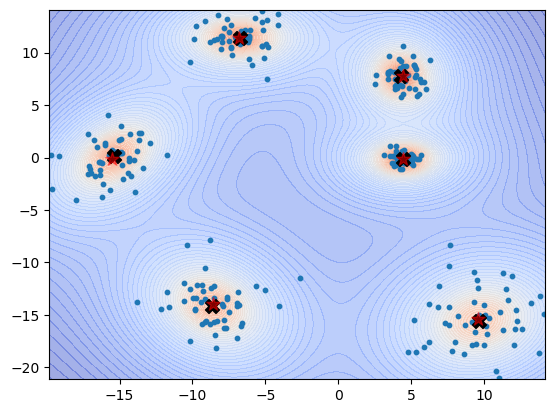

In [6]:
# plot the tmm
plt.contourf(x, y, probs, levels=64, cmap="coolwarm", alpha=0.5)
# plt.contourf(x, y, gmm_probs, levels=64, cmap="coolwarm", alpha=0.5)
plt.scatter(data_X[:,0], data_X[:,1], s=10, label="raw data")

# cluster centers (tmm and gmm)
plt.scatter(stm.location[:,0], stm.location[:,1], color="black", marker="X",
               label="Student's t-mixture", s=100)
plt.scatter(gm.means_[:,0], gm.means_[:,1], color="red", marker="*", 
                label="Gaussian mixture", alpha=0.5, s=100)
# plt.legend()

In [29]:
# jax_t_probs = jax_neb.t_logpdf(x=XY.reshape(-1,2), loc=stm.location[0], shape=np.transpose(stm.scale, (2,0,1))[0], df=1.0).reshape(128,128)

In [35]:
jax_t_probs = jax_neb.tmm_jax(x=XY.reshape(-1,2), means=stm.location, scales=np.transpose(stm.scale, (2,0,1)), weights=stm.mix_weights).reshape(128,128)

In [37]:
print(np.max(np.abs(jax_t_probs - probs)))

1.9073486e-06


In [39]:
i=1
j=2

In [62]:
n_components**2

36

In [60]:
adjacency = np.zeros((n_components,n_components))
paths = dict()
temps = dict()
logprobs = dict()

for i, j in tqdm.tqdm(itertools.product(range(n_components), repeat=2), total=n_components**2):
        # compute nudged elastic band
        path_positions, temperatures, interpolation_probs = jax_neb.compute_interpolation(i,j,means=stm.location, covs=np.transpose(stm.scale, (2,0,1)), weights=stm.mix_weights, iterations=5000)
        paths[(i,j)] = path_positions
        temps[(i,j)] = temperatures
        logprobs[(i,j)] = interpolation_probs
        
        # evaluate score of elastic band
        score = jax_neb.score_interpolation(interpolation_probs)
        adjacency[i,j] = score
        
        # in case something goes wrong with the initialisation
        if np.isnan(interpolation_probs).any():
            print("nan in", i, j)
            continue
        
        

100%|██████████| 36/36 [04:24<00:00,  7.34s/it]


In [46]:
adjacency

array([[0.        , 7.28782368, 5.35915947, 5.10834122, 4.75668907,
        5.14177132],
       [7.28782463, 0.        , 4.58662128, 4.49050045, 4.82839966,
        5.93830824],
       [5.35915852, 4.58662128, 0.        , 5.48503685, 5.82123947,
        4.96307468],
       [5.10834026, 4.49050045, 5.48503685, 0.        , 4.66236877,
        5.95724821],
       [4.75668907, 4.82840061, 5.82123947, 4.66236877, 0.        ,
        5.23250771],
       [5.14177227, 5.93830824, 4.96307468, 5.95724726, 5.23250771,
        0.        ]])

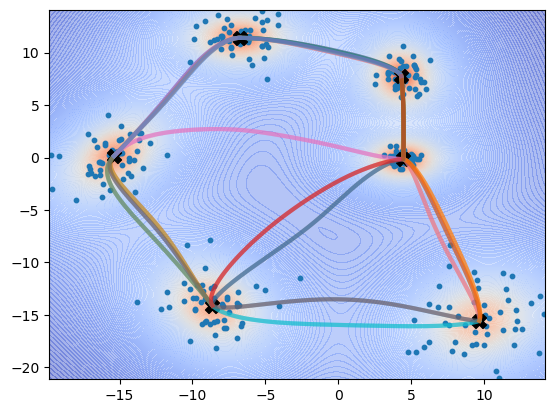

In [64]:
# plot the tmm
plt.contourf(x, y, probs, levels=200, cmap="coolwarm", alpha=0.5)
# plt.contourf(x, y, gmm_probs, levels=64, cmap="coolwarm", alpha=0.5)
plt.scatter(data_X[:,0], data_X[:,1], s=10, label="raw data")

# cluster centers (tmm and gmm)
plt.scatter(stm.location[:,0], stm.location[:,1], color="black", marker="X",
               label="Student's t-mixture", s=100)

# path = paths[(0,1)]
# plt.plot(path[:, 0], path[:, 1], lw=3, alpha=0.5)

for i in range(n_components):
    for j in range(n_components):
        path = paths[(i,j)]
        plt.plot(path[:, 0], path[:, 1], lw=3, alpha=0.5)



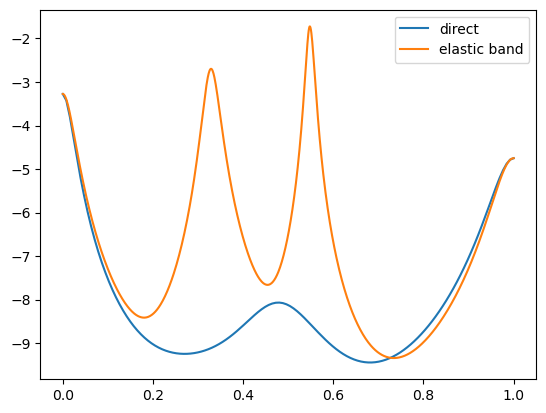

In [78]:
i=0
j=1

# the direct line
direct_x = np.linspace(0,1,num=128)[..., None]
ms = (1 - direct_x) * stm.location[i] + direct_x * stm.location[j]
direct_y = stm.score_samples(ms)
plt.plot(direct_x[:,0],direct_y, label="direct")

plt.plot(temps[(i,j)],logprobs[(i,j)], label="elastic band")
plt.legend()

In [73]:
ms

array([[ -6.7681069 ,  11.40770188],
       [ -6.63877176,  11.19537015],
       [ -6.50943661,  10.98303841],
       [ -6.38010146,  10.77070668],
       [ -6.25076631,  10.55837495],
       [ -6.12143116,  10.34604321],
       [ -5.99209602,  10.13371148],
       [ -5.86276087,   9.92137974],
       [ -5.73342572,   9.70904801],
       [ -5.60409057,   9.49671628],
       [ -5.47475542,   9.28438454],
       [ -5.34542028,   9.07205281],
       [ -5.21608513,   8.85972108],
       [ -5.08674998,   8.64738934],
       [ -4.95741483,   8.43505761],
       [ -4.82807969,   8.22272588],
       [ -4.69874454,   8.01039414],
       [ -4.56940939,   7.79806241],
       [ -4.44007424,   7.58573068],
       [ -4.31073909,   7.37339894],
       [ -4.18140395,   7.16106721],
       [ -4.0520688 ,   6.94873547],
       [ -3.92273365,   6.73640374],
       [ -3.7933985 ,   6.52407201],
       [ -3.66406336,   6.31174027],
       [ -3.53472821,   6.09940854],
       [ -3.40539306,   5.88707681],
 